# 🍷 Анализ рынка вина: что влияет на цену и рейтинг?

## Описание проекта 
Исследование данных о винах для выявления факторов, влияющих на цену и рейтинг. 
Сравнительный анализ традиционных (Старый Свет) и новых (Новый Свет) винодельческих регионов.

**Источник данных:** [Kaggle - Wine Reviews](https://www.kaggle.com/datasets/zynicide/wine-reviews)

## Задачи этапа "Предобработка данных":
* Очистка данных и удаление дубликатов
* Обработка пропущенных значений
* Feature Engineering — создание новых признаков
* Анализ базовой статистики
* Сохранение очищенного набора данных

## Оглавление

1. Импорт библиотек
2. Загрузка данных
3. Удаление дубликатов
4. Обработка пропущенных значений
5. Feature Engineering — создание новых признаков
6. Описательная статистика
7. Сохранение очищенного датасета
8. Выводы по этапу предобработки данных

---

## Описание данных
Набор данных состоит из 13 признаков (2 числовых и 11 категориальных):

| Признак | Тип | Описание |
|---------|-----|----------|
| `country` | Категориальный | Страна происхождения вина |
| `description` | Текстовый | Описание вкусового профиля вина |
| `designation` | Категориальный | Виноградник, ягоды которого используются при изготовлении вина |
| `points` | Числовой | Оценка вина по шкале от 1 до 100 |
| `price` | Числовой | Стоимость одной бутылки вина |
| `province` | Категориальный | Место изготовления вина (провинция или штат) |
| `region_1` | Категориальный | Винодельческая область в провинции |
| `region_2` | Категориальный | Конкретная зона виноделия в области |
| `variety` | Категориальный | Сорт винограда для изготовления вина |
| `winery` | Категориальный | Винодельня-производитель вина |
| `taster_name` | Текстовый | Имя автора рецензии            
| `taster_twitter_handle` | Текстовый | Твиттер-аккаунт рецензента

## 1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_theme(style='white', palette='rocket', color_codes=True)
import squarify

from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

from scipy.stats import shapiro

from sklearn.preprocessing import MinMaxScaler
from scipy import stats as st
import scipy

import warnings; warnings.filterwarnings('ignore', category=FutureWarning)

## 2. Загрузка данных

Данные взяты из открытого источника (платформы Kaggle) в формате *.csv

In [2]:
df = pd.read_csv('../data/winemag-data-130k-v2.csv')
df.sample(2)

Unnamed: 0 country                                        description  \
75846       75846      US  An apt name for this richly fruited and supple...   
11858       11858   Italy  Frappato is usually made as a dry red wine and...   

          designation  points  price           province         region_1  \
75846  Velvet Sisters      90   50.0         California  Anderson Valley   
11858     Uniku 500ml      84   26.0  Sicily & Sardinia          Sicilia   

      region_2 taster_name taster_twitter_handle  \
75846      NaN         NaN                   NaN   
11858      NaN         NaN                   NaN   

                                                   title     variety  \
75846  Hartford 1999 Velvet Sisters Pinot Noir (Ander...  Pinot Noir   
11858  Terre di Giurfo 2009 Uniku 500ml Frappato (Sic...    Frappato   

                winery  
75846         Hartford  
11858  Terre di Giurfo

Для дальнейшего анализа необходимо изучить данные.  
Первичный осмотр данных: df.info()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


Количество значений в столбцах отличается. Это говорит о том, что в данных есть пустые значения.  
Признаки `points` и `price` - числовые.

## 3. Удаление дубликатов

`Unnamed: 0` - удаляем технический индекс (создаёт видимость отсутствия дубликатов)

In [4]:
columns_to_drop = ['Unnamed: 0'] 
df = df.drop(columns_to_drop, axis=1)

In [5]:
print('Дубликаты до очистки:', df.duplicated().sum())
print(f'📊 Размер датасета до очистки: {df.shape[0]:,} строк')

Дубликаты до очистки: 9983
📊 Размер датасета до очистки: 129,971 строк


Было обнаружено 9983 полных дубликата - идентичных записей по всем признакам, включая текстовое описание.  
**Принятое решение:** Удалить все дубликаты, оставив первое вхождение, чтобы избежать смещения в анализе.

In [6]:
df = df.drop_duplicates(keep='first')
print('Размер датасета после очистки:', df.shape)

Размер датасета после очистки: (119988, 13)


## 4. Обработка пропущенных значений

* Признаки, связанные с экспертной оценкой (**taster_name**, **taster_twitter_handle**), сохранены без изменений для анализа в соответствующем разделе исследования.

*Примечание: Детальный разбор экспертной составляющей перенесен в раздел  "Анализ экспертов".* (02_EDA_Analysis.ipynb)

Количество пустых значений для каждого признака:

In [7]:
df.isna().sum()

country                     59
description                  0
designation              34545
points                       0
price                     8395
province                    59
region_1                 19560
region_2                 73219
taster_name              24917
taster_twitter_handle    29446
title                        0
variety                      1
winery                       0
dtype: int64

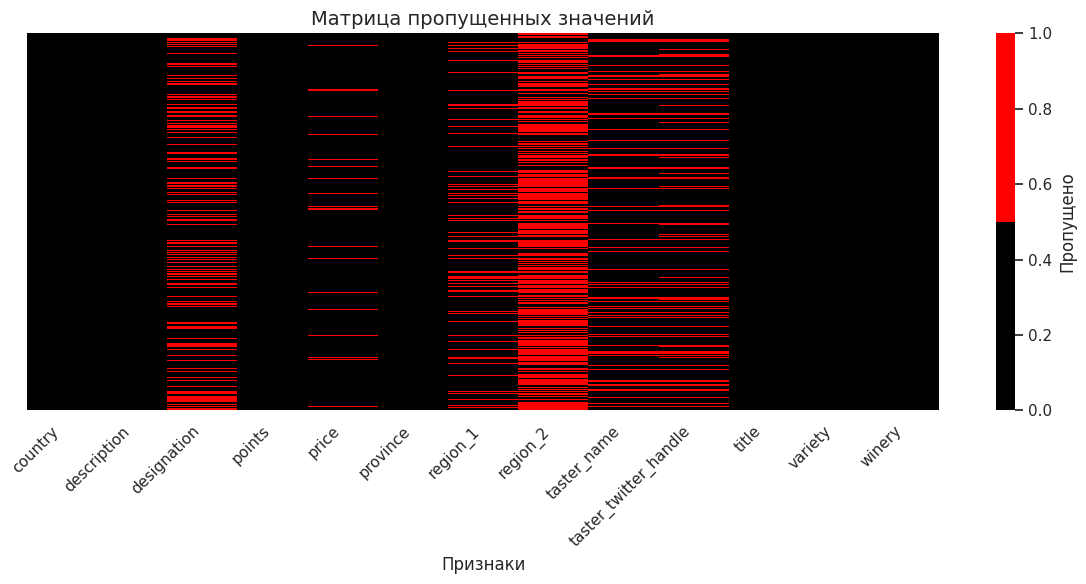

In [8]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), 
            yticklabels=False,  
            cbar_kws={'label': 'Пропущено'},
            cmap=['black', 'red'])

plt.title('Матрица пропущенных значений', fontsize=14)
plt.xlabel('Признаки', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylabel('') 
plt.tight_layout()
plt.show()

Процент пустых значений для каждого признака:

In [9]:
lost_values = df.isna().sum()
percentage = lost_values/(df.isna().count())
lost_data = pd.concat([lost_values, percentage],
                      axis=1, keys=['lost_values', 'percentage'])*100
lost_data.sort_values(by=['percentage'], ascending=False)

lost_values  percentage
region_2                   7321900   61.021936
designation                3454500   28.790379
taster_twitter_handle      2944600   24.540787
taster_name                2491700   20.766243
region_1                   1956000   16.301630
price                       839500    6.996533
province                      5900    0.049172
country                       5900    0.049172
variety                        100    0.000833
points                           0    0.000000
description                      0    0.000000
title                            0    0.000000
winery                           0    0.000000

* **Unnamed: 0** - технических столбец, удаляется
* Столбец с признаком **region_2**, незаполненный на 61,1% удаляется

In [10]:
columns_to_drop = ['region_2'] 
df = df.drop(columns_to_drop, axis=1)

* **designation** (виноградник), незаполненный на 28,8%  
  заполняем значением 'Unknown' (не известен)

In [11]:
df['designation'] = df['designation'].fillna('Unknown')

* **region_1** (16,3% пропусков)  
заполняю из province (есть все значения, географическое название уровнем выше)

In [12]:
df['region_1'] = df['region_1'].fillna(df['province'])

* **price** (6,9% пропусков), очень важный признак  
  заполняю методом иерархического заполнения (от частного к общему)

In [13]:
warnings.filterwarnings('ignore')

df['price'] = df.groupby(['country', 'province', 'variety'])['price'].transform(
    lambda x: x.fillna(x.median())
)
df['price'] = df.groupby(['country', 'variety'])['price'].transform(
    lambda x: x.fillna(x.median())
)
df['price'] = df.groupby('variety')['price'].transform(
    lambda x: x.fillna(x.median())
)
df['price'] = df['price'].fillna(df['price'].median())

In [14]:
df.isna().sum()

country                     59
description                  0
designation                  0
points                       0
price                        0
province                    59
region_1                    59
taster_name              24917
taster_twitter_handle    29446
title                        0
variety                      1
winery                       0
dtype: int64

* **country**, **province**, **region_1**

Проверка полного совпадения пропусков

In [15]:
country_na = set(df[df['country'].isna()].index)
province_na = set(df[df['province'].isna()].index)  
region_na = set(df[df['region_1'].isna()].index)

print(f"- Только country: {len(country_na - province_na - region_na)}")
print(f"- Только province: {len(province_na - country_na - region_na)}")
print(f"- Только region_1: {len(region_na - country_na - province_na)}")
print(f"- country + province: {len(country_na & province_na - region_na)}")
print(f"- country + region_1: {len(country_na & region_na - province_na)}")
print(f"- province + region_1: {len(province_na & region_na - country_na)}")
print(f"- Все три: {len(country_na & province_na & region_na)}")

- Только country: 0
- Только province: 0
- Только region_1: 0
- country + province: 0
- country + region_1: 0
- province + region_1: 0
- Все три: 59


59 строк не содержат географического контекста

In [16]:
no_geo_data = df[df['country'].isna() & df['province'].isna() & df['region_1'].isna()]

print("Характеристики строк без географических данных:")
print(f"Количество: {len(no_geo_data)}")
print(f"Уникальные сорта: {no_geo_data['variety'].nunique()}")
print(f"Уникальные винодельни: {no_geo_data['winery'].nunique()}")
print(f"Диапазон цен: у.е.{no_geo_data['price'].min():.0f} - у.е.{no_geo_data['price'].max():.0f}")
print(f"Диапазон рейтингов: {no_geo_data['points'].min()} - {no_geo_data['points'].max()}")


Характеристики строк без географических данных:
Количество: 59
Уникальные сорта: 31
Уникальные винодельни: 27
Диапазон цен: у.е.16 - у.е.43
Диапазон рейтингов: 82 - 92


Дальнейшие исследования будут основаны на географии, удаляю данные без этих признаков.

In [17]:
count_before = len(df)
df = df.dropna(subset=['country', 'province', 'region_1'], how='all')
count_after = len(df)
print(f"Удалено {count_before - count_after} строк без географических данных")

Удалено 59 строк без географических данных


* **variety** - 1 шт

In [18]:
df = df[df['variety'].notna()]

* финальная проверка пропусков

In [19]:
df.isna().sum()

country                      0
description                  0
designation                  0
points                       0
price                        0
province                     0
region_1                     0
taster_name              24916
taster_twitter_handle    29445
title                        0
variety                      0
winery                       0
dtype: int64

In [20]:
df.sample()

country                                        description designation  \
65288   Chile  Herbal, peppery berry aromas are spicy and pus...     Unknown   

       points  price      province      region_1        taster_name  \
65288      88   57.0  Maipo Valley  Maipo Valley  Michael Schachner   

      taster_twitter_handle                           title    variety  winery  
65288           @wineschach  Lafken 2009 Red (Maipo Valley)  Red Blend  Lafken

## 5. Feature Engineering - создание новых признаков

Создание признаков для углубленного анализа.  
Добавлены дополнительные характеристики:

- **`continent`** - континент происхождения вина
- **`color`** - цвет вина (red/white)
- **`year`** - год производства

### **continent** (континент)

In [21]:
country_to_continent = {
    'Italy': 'Europe',
    'Portugal': 'Europe',
    'US': 'North America',
    'Spain': 'Europe',
    'France': 'Europe',
    'Germany': 'Europe',
    'Argentina': 'Latin America',
    'Chile': 'Latin America',
    'Australia': 'Oceania',
    'Austria': 'Europe',
    'South Africa': 'Africa',
    'New Zealand': 'Oceania',
    'Israel': 'Asia',
    'Hungary': 'Europe',
    'Greece': 'Europe',
    'Romania': 'Europe',
    'Mexico': 'Latin America',
    'Canada': 'North America',
    'Turkey': 'Asia',
    'Czech Republic': 'Europe',
    'Slovenia': 'Europe',
    'Luxembourg': 'Europe',
    'Croatia': 'Europe',
    'Georgia': 'Europe',
    'Uruguay': 'Latin America',
    'England': 'Europe',
    'Lebanon': 'Asia',
    'Serbia': 'Europe',
    'Brazil': 'Latin America',
    'Moldova': 'Europe',
    'Morocco': 'Africa',
    'Peru': 'Latin America',
    'India': 'Asia',
    'Bulgaria': 'Europe',
    'Cyprus': 'Europe',
    'Armenia': 'Asia',
    'Switzerland': 'Europe',
    'Bosnia and Herzegovina': 'Europe',
    'Ukraine': 'Europe',
    'Slovakia': 'Europe',
    'Macedonia': 'Europe',
    'China': 'Asia',
    'Egypt': 'Africa',
    'Montenegro': 'Europe',
    'South Korea': 'Asia', 
    'US-France': 'North America'
}

In [22]:
df['continent'] = df['country'].map(country_to_continent)

### **color** (цвет вина)

In [23]:
color = {
    'Chardonnay': 'white',
    'Pinot Noir': 'red',
    'Cabernet Sauvignon': 'red',
    'Red Blend': 'red',
    'Bordeaux-style Red Blend': 'red',
    'Sauvignon Blanc': 'white',
    'Syrah': 'red',
    'Riesling': 'white',
    'Merlot': 'red',
    'Zinfandel': 'red',
    'Sangiovese': 'red',
    'Malbec': 'red',
    'White Blend': 'white',
    'Rosé': 'rose', 
    'Tempranillo': 'red',
    'Nebbiolo': 'red',
    'Portuguese Red': 'red',
    'Sparkling Blend': 'sparkling',
    'Shiraz': 'red',
    'Corvina, Rondinella, Molinara': 'red',
    'Rhône-style Red Blend': 'red',
    'Barbera': 'red',
    'Pinot Gris': 'white',
    'Viognier': 'white',
    'Bordeaux-style White Blend': 'white',
    'Champagne Blend': 'sparkling', 
    'Port': 'red',
    'Grüner Veltliner': 'white',
    'Gewürztraminer': 'white',
    'Portuguese White': 'white',
    'Petite Sirah': 'red',
    'Carmenère': 'red',
    'Portuguese Sparkling': 'sparkling',
    'Portuguese Rosé': 'rose',
    'Provence rosé': 'rose',
    'Rosado': 'rose',
    'Grenache': 'red',
    'Gamay': 'red',
    'Primitivo': 'red',
    "Nero d'Avola": 'red',
    'Frappato': 'red',
    'Monica': 'red',
    'Graciano': 'red',
    'Blaufränkisch': 'red',
    'G-S-M': 'red',
    'Furmint': 'white',
    'Catarratto': 'white',
    'Grillo': 'white',
    'Assyrtico': 'white',
    'Friulano': 'white',
    'Petit Manseng': 'white',
    'Meritage': 'red',
    'Prugnolo Gentile': 'red',
    'Touriga Nacional': 'red'
}

In [24]:
df['color'] = df['variety'].map(color)

In [25]:
df.isna().sum()

country                      0
description                  0
designation                  0
points                       0
price                        0
province                     0
region_1                     0
taster_name              24916
taster_twitter_handle    29445
title                        0
variety                      0
winery                       0
continent                    0
color                    19333
dtype: int64

Сорта винограда, для которых не указан цвет в исходном словаре:

In [26]:
missing_color_varieties = df[df['color'].isna()]['variety'].unique()
print(f'Сорта без цвета: {len(missing_color_varieties)} шт')

Сорта без цвета: 648 шт


In [27]:
variety_counts = df[df['color'].isna()]['variety'].value_counts()
variety_counts.head(5)

variety
Cabernet Franc       1242
Pinot Grigio          980
Sangiovese Grosso     696
Glera                 646
Tempranillo Blend     553
Name: count, dtype: int64

Ключевые слова по категориям для дальнейшей классификации вин:

In [28]:
missing_color_varieties

array(['Tempranillo-Merlot', 'Nerello Mascalese', 'Tempranillo Blend',
       'Chenin Blanc', 'Viognier-Chardonnay', 'Inzolia', 'Petit Verdot',
       'Cabernet Franc', 'Aglianico', 'Albariño', 'Vernaccia', 'Rosato',
       'Vermentino', 'Grenache Blanc', 'Shiraz-Cabernet Sauvignon',
       'Pinot Blanc', 'Alsace white blend', 'Tannat-Cabernet',
       'Sauvignon', 'Sangiovese Grosso', 'Torrontés', 'Verdejo',
       'Fumé Blanc', 'Pinot Bianco', 'Bonarda', 'Montepulciano',
       'Moscato', 'Ugni Blanc-Colombard', 'Syrah-Viognier',
       'Carignan-Grenache', 'Sagrantino', 'Savagnin',
       'Cabernet Sauvignon-Syrah', 'Prosecco', 'Vignoles', 'Muscat',
       'Muscadelle', 'Shiraz-Viognier', 'Garganega', 'Pinot Grigio',
       'Zierfandler', 'Cortese', 'Mencía', 'Zweigelt', 'Melon',
       'Rhône-style White Blend', 'Vidal', 'Cannonau', 'Verdelho',
       'Marsanne', 'Scheurebe', 'Kerner', 'Syrah-Grenache', 'Dolcetto',
       'Vilana', 'Glera', 'Viura', 'Garnacha Tintorera', 'Pinot Ner

In [29]:
WHITE_KEYWORDS = [
    'blanc', 'white', 'chardonnay', 'sauvignon', 'riesling', 'viognier', 
    'gewürz', 'pinot gris', 'pinot grigio', 'verdejo', 'albariño', 'vermentino',
    'chenin blanc', 'semillon', 'fumé blanc', 'marsanne', 'pinot blanc',
    'vernaccia', 'silvaner', 'malvasia', 'garganega', 'roussanne', 
    'torrontés', 'verdicchio', 'trebbiano', 'verdelho', 'fiano', 'godello',
    'pecorino', 'arneis', 'greco', 'aligoté', 'cortese', 'macabeo',
    'inzolia', 'auxerrois', 'grauburgunder', 'savatiano', 'greco bianco',
    'weissburgunder', 'müller-thurgau', 'scheurebe', 'kerner', 'sylvaner',
    'fiano', 'früburgunder', 'avesso', 'xarel-lo', 'greco', 'ribolla gialla',
    'weissburgunder', 'traminer', 'marsanne-roussanne', 'prié blanc',
    'muscadelle', 'bical', 'viura-chardonnay', 'gelber muskateller',
    'turbiana', 'alvarinho', 'manzoni', 'malagousia', 'assyrtiko',
    'welschriesling', 'rieslaner', 'traminette', 'seyval blanc',
    'muscat canelli', 'arinto', 'pecorino', 'rotgipfler', 'picpoul',
    'vidal blanc', 'albanello', 'arneis', 'altesse', 'blanc du bois',
    'nosiola', 'godello', 'pedro ximénez', 'auxerrois', 'albana',
    'carricante', 'encruzado', 'torbato', 'pallagrello', 'siria',
    'asprinio', 'feteascǎ regalǎ', 'sideritis', 'viosinho', 'malvar',
    'airen', 'erbaluce', 'verdosilla', 'biancolella', 'rolle',
    'orangetraube', 'žilavka', 'gouveio', 'bombino bianco',
    'sauvignon musqué', 'rivaner', 'doña blanca', 'graševina',
    'cococciola', 'romorantin', 'savatiano', 'rebula', 'bacchus',
    'azal', 'paralleda', 'maria gomes', 'biancolella', 'aidani',
    'bombino bianco', 'grolleau', 'zlahtina', 'elbling', 'misket',
    'robola', 'folle blanche', 'meseguera', 'biancu gentile',
    'verdeca', 'cayuga', 'biancale', 'ansonica', 'sercial', 'jampal',
    'trajadura', 'catalanesca', 'favorita', 'dafni', 'kotsifali',
    'roscetto', 'torontel', 'athiri'
]
RED_KEYWORDS = [
    'noir', 'cabernet', 'merlot', 'syrah', 'shiraz', 'malbec', 'tempranillo',
    'sangiovese', 'nebbiolo', 'zinfandel', 'pinotage', 'garnacha', 'mourvèdre',
    'tannat', 'petit verdot', 'primitive', 'monastrell', 'carignan', 'dolcetto',
    'bonarda', 'montepulciano', 'aglianico', 'nerello', 'xinomavro', 'cannonau',
    'teroldego', 'lagrein', 'baco noir', 'norton', 'saperavi', 'gaglioppo',
    'uva di troia', 'feteasca neagra', 'boğazkere', 'negrette', 'graciano',
    'blaufränkisch', 'frappato', 'monica', 'prugnolo gentile', 'touriga nacional',
    'meritage', 'petit verdot', 'cinsault', 'tinta miúda', 'monastrell',
    'negroamaro', 'mourvèdre', 'müller-thurgau', 'pinot meunier', 'teroldego',
    'pansa blanca', 'muskat ottonel', 'claret', 'baga', 'refosco',
    'aragonês', 'agiorgitiko', 'ruché', 'tinta de toro', 'cabernet moravia',
    'chambourcin', 'nero di troia', 'cesanese', 'feteasca neagra', 'lagrein',
    'tinta fina', 'st. laurent', 'pugnitello', 'cerceal', 'tinta roriz',
    'grenache-syrah', 'cabernet merlot', 'aragonez', 'magliocco', 'gamay noir',
    'spätburgunder', 'lemberger', 'saperavi', 'mondeuse', 'perricone',
    'carignano', 'pallagrello', 'morava', 'aleatico', 'carcajolu', 'kisi',
    'palomino', 'nascetta', 'schiava', 'alfrocheiro', 'corvina', 'norton',
    'alicante bouschet', 'carignan', 'black muscat', 'grenache noir',
    'durella', 'xinomavro', 'petite verdot', 'valdiguié', 'kangoun',
    'loureiro', 'posip', 'gros and petit manseng', 'jacquère', 'kalecik karasi',
    'karasakiz', 'negrette', 'raboso', 'país', 'mauzac', 'diamond', 'marzemino',
    'tinta barroca', 'castelão', 'teran', 'trepat', 'freisa', 'marzemino',
    'merlot-tannat', 'rkatsiteli', 'trousseau gris', 'brachetto', 'mantonico',
    'ekigaïna', 'muskateller', 'argaman', 'bobal', 'baco noir', 'veltliner',
    'morillon', 'touriga franca', 'picolit', 'prieto picudo', 'gaglioppo',
    'sacy', 'piedirosso', 'mansois', 'susumaniello', 'vitovska', 'carignane',
    'nerello cappuccio', 'counoise', 'macabeo', 'mazuelo', 'vranec', 'mavrud',
    'debit', 'verdil', 'cabernet', 'treixadura', 'coda di volpe', 'forcallà',
    'bombino nero', 'mavrotragano', 'bovale', 'frankovka', 'gragnano',
    'schwartzriesling', 'petit meslier', 'bastardo', 'vidadillo', 'babić',
    'roviello', 'yapincak', 'mandilaria', 'teroldego rotaliano',
    'trebbiano di lugana', 'albarossa', 'black monukka', 'chardonel',
    'uvalino', 'boğazkere', 'vermentino nero', 'tinta amarela',
    'tinta negra mole', 'chelois', 'durif', 'franconia', 'nasco', 'sirica',
    'vital', 'espadeiro', 'blatina', 'karalahna', 'colorino', 'centesimino',
    'ramisco', 'gamza', 'mavrokalavryta', 'babosa negro', 'petit courbu',
    'parraleta', 'francisa', 'kuntra', 'pignolo', 'caprettone', 'ondenc'
]
ROSE_KEYWORDS = [
    'rosé', 'rose', 'rosado', 'rosato', 'pink', 'blush', 
    'vin rosé', 'rosé wine', 'pink wine', 'blush wine',
    'weissherbst', 'clairet', 'schillerwein', 'rosato'
]
SPARKLING_KEYWORDS = [
    'sparkling', 'champagne', 'prosecco', 'spätburgunder', 
    'claret', 'sherry', 'port', 'madeira', 'lambrusco',
    'brachetto', 'pied de perdrix', 'cava', 'crémant',
    'franciacorta', 'asti', 'sekt', 'moscato d\'asti',
    'cap classique', 'espumante', 'método tradicional',
    'traditional method', 'charmat', 'pét-nat', 'pétillant',
    'frizzante', 'mousseux', 'pearl', 'bubbly',
    'carbonated', 'effervescent', 'prosecco'
]

In [30]:
def color_detection(variety_name):
    if pd.isna(variety_name):
        return 'unknown'
    
    variety_lower = str(variety_name).lower()

    if any(keyword in variety_lower for keyword in ROSE_KEYWORDS):
        return 'rose'
    
    elif any(keyword in variety_lower for keyword in SPARKLING_KEYWORDS):
        return 'sparkling'
    
    elif any(keyword in variety_lower for keyword in WHITE_KEYWORDS):
        return 'white'
    
    elif any(keyword in variety_lower for keyword in RED_KEYWORDS):
        return 'red'
    
    elif 'blend' in variety_lower:
        if 'white' in variety_lower:
            return 'white'
        elif 'red' in variety_lower:
            return 'red'
        elif 'rosé' in variety_lower or 'rose' in variety_lower:
            return 'rose'
        elif 'sparkling' in variety_lower:
            return 'sparkling'
        else:
            return 'unknown'
    
    else:
        return 'unknown'

Итого категории цвета:
* **`red`** - красные
* **`white`** - белые
* **`sparkling`** - игристые
* **`rose`** - розовые
* **`unknown`** - неизвестные

In [31]:
df['color'] = df['color'].fillna(df['variety'].apply(color_detection))

print('Оставшиеся пропуски:', df['color'].isna().sum())
print('\nРаспределение цветов:')
print(df['color'].value_counts())

Оставшиеся пропуски: 0

Распределение цветов:
color
red          71969
white        37280
rose          3635
sparkling     3632
unknown       3412
Name: count, dtype: int64


Применяем ту же функцию `color_detection` к `title` вместо `variety`

In [32]:
unknown_mask = df['color'] == 'unknown'
df.loc[unknown_mask, 'color'] = df.loc[unknown_mask, 'title'].apply(color_detection)

print("Результаты применения color_detection к title:")
print(f"Было unknown: {unknown_mask.sum()}")
print(f"Стало unknown: {(df['color'] == 'unknown').sum()}")
print(f"Улучшено классификаций: {unknown_mask.sum() - (df['color'] == 'unknown').sum()}")

print("\nФинальное распределение цветов:")
print(df['color'].value_counts())

Результаты применения color_detection к title:
Было unknown: 3412
Стало unknown: 2429
Улучшено классификаций: 983

Финальное распределение цветов:
color
red          71973
white        37394
rose          4311
sparkling     3821
unknown       2429
Name: count, dtype: int64


Все пропуски заполнены  

**Многоуровневая классификация:**
 **Первичная:** На основе сорта винограда (variety) - 97% успеха
2. **Вторичная:** На основе названия вина (title) - дополнительно 983 вина

**Финальное распределение:**
- Красные: 60.0% (71,973)
- Белые: 32% (37,394) 
- Розовые: 3.6% (4,311)
- Игристые: 3.2% (3,821)
- Неизвестные: 2.0% (2,429)

**Эффективность:** 98% вин успешно классифицированы

### **year**  
  Отбираются только реальные годы, диапазон (1900-2025)

In [33]:
df['year'] = df['title'].str.extract(r'\b(19[0-9]{2}|20[0-1][0-9]|202[0-5])\b').astype('Int64')

print("Статистика по годам после фильтрации:")
print(f"Извлечено: {df['year'].notna().sum()} записей")
print(f"Диапазон: {df['year'].min()} - {df['year'].max()}")

Статистика по годам после фильтрации:
Извлечено: 115645 записей
Диапазон: 1904 - 2017


* Создание возрастных групп
  2017 - последний год в данных

In [34]:
df['wine_age'] = 2017 - df['year']
df['age_category'] = pd.cut(df['wine_age'], 
                           bins=[0, 3, 10, 20, 50, df['wine_age'].max()],
                           labels=['Молодое', 'Выдержанное', 'Зрелое', 'Винтаж', 'Антиквар'])

In [35]:
df['age_category'].value_counts()

age_category
Выдержанное    74539
Молодое        26235
Зрелое         14623
Винтаж           203
Антиквар          34
Name: count, dtype: int64

In [36]:
df.isna().sum()

country                      0
description                  0
designation                  0
points                       0
price                        0
province                     0
region_1                     0
taster_name              24916
taster_twitter_handle    29445
title                        0
variety                      0
winery                       0
continent                    0
color                        0
year                      4283
wine_age                  4283
age_category              4294
dtype: int64

## 6. Описательная статистика

* Категориальные признаки

In [37]:
df.describe(include=['O'])

country                                        description designation  \
count   119928                                             119928      119928   
unique      43                                             119895       37955   
top         US  Seductively tart in lemon pith, cranberry and ...     Unknown   
freq     50457                                                  2       34534   

          province     region_1 taster_name taster_twitter_handle  \
count       119928       119928       95012                 90483   
unique         425         1601          19                    15   
top     California  Napa Valley  Roger Voss            @vossroger   
freq         33656         4174       23558                 23558   

                                                    title     variety  \
count                                              119928      119928   
unique                                             118780         701   
top     Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...  Pinot Noir   
freq                                                    9       12275   

                    winery continent   color  
count               119928    119928  119928  
unique               16745         6       5  
top     Wines & Winemakers    Europe     red  
freq                   211     55896   71973

In [38]:
print('В наборе данных представлено:')
print(f'- {df['country'].nunique()} стран (самая часто встречающаяся - {df['country'].mode()[0]})')
print(f'- {df['province'].nunique()} провинций (самая часто встречающаяся - {df['province'].mode()[0]})')
print(f'- {df['variety'].nunique()} сортов винограда (самый часто встречающийся - {df['variety'].mode()[0]})')
print(f'- {df['color'].nunique()} цветов вина (самый часто встречающийся - {df['color'].mode()[0]})')

В наборе данных представлено:
- 43 стран (самая часто встречающаяся - US)
- 425 провинций (самая часто встречающаяся - California)
- 701 сортов винограда (самый часто встречающийся - Pinot Noir)
- 5 цветов вина (самый часто встречающийся - red)


* Числовые признаки

In [39]:
df.describe()

points          price         year  wine_age
count  119928.000000  119928.000000     115645.0  115645.0
mean       88.442149      35.215521  2010.572476  6.427524
std         3.093287      40.840919     3.846875  3.846875
min        80.000000       4.000000       1904.0       0.0
25%        86.000000      17.000000       2009.0       4.0
50%        88.000000      25.000000       2011.0       6.0
75%        91.000000      42.000000       2013.0       8.0
max       100.000000    3300.000000       2017.0     113.0

In [40]:
print(f'Числовые признаки:')
print(f'- Диапазон изменения рейтинга {df['points'].min()}-{df['points'].max()}. Среднее значение {df['points'].mean():.1f}. Медианное значение {df['points'].median()}.')
print(f'- Диапазон изменения стоимости от {df['price'].min():.0f} у.е. до {df['price'].max():.0f} у.е. Среднее значение = {df['price'].mean():.2f} у.е. Медианное {df['price'].median():.0f} у.е.')

Числовые признаки:
- Диапазон изменения рейтинга 80-100. Среднее значение 88.4. Медианное значение 88.0.
- Диапазон изменения стоимости от 4 у.е. до 3300 у.е. Среднее значение = 35.22 у.е. Медианное 25 у.е.


Такое различие может говорить о наличии аномально высоких значений по цене.

In [41]:
print(f'Общая информация:')
print(f'- Размер датасета: {df.shape[0]:,} строк, {df.shape[1]} столбцов')

Общая информация:
- Размер датасета: 119,928 строк, 17 столбцов


## 7. Сохранение очищенного датасета

Сохраняем очищенный датасет для последующего использования

In [42]:
df_cleaned = df.copy()
df_cleaned.to_csv('../data/wine_reviews_cleaned.csv', index=False)

print("Датасет успешно сохранен: wine_reviews_cleaned.csv")
print(f"Размер: {df_cleaned.shape[0]:,} строк, {df_cleaned.shape[1]} столбцов")

Датасет успешно сохранен: wine_reviews_cleaned.csv
Размер: 119,928 строк, 17 столбцов


Проверка сохранённого файла

In [43]:
df_check = pd.read_csv('../data/wine_reviews_cleaned.csv')
print(f"- Размер: {df_check.shape[0]:,} строк × {df_check.shape[1]} столбцов")
print(f"- Пропуски: {df_check.isna().sum().sum()} (обработаны)")
print(f"- Дубликаты: {df_check.duplicated().sum()}")

- Размер: 119,928 строк × 17 столбцов
- Пропуски: 67221 (обработаны)
- Дубликаты: 0


## 8. Выводы по этапу предобработки данных

### 🎯 Ключевые результаты обработки

#### 📊 Качество данных
- **Исходный размер:** 129,971 × 14 признаков
- **Удалено дубликатов:** 9,983 (7.7% исходных данных)
- **Финальный размер:** 119,988 × 17 признаков
- **Заполненность ключевых признаков:** 100%

#### 🆕 Созданные признаки
| Признак | Тип | Описание | Заполненность |
|---------|-----|----------|---------------|
| `continent` | Категориальный | Континент происхождения | 100% |
| `color` | Категориальный | Цвет вина (5 категорий) | 100% |
| `year` | Числовой | Год производства | 96.4% |
| `wine_age` | Числовой | Возраст вина | 96.4% |
| `age_category` | Категориальный | Категория выдержки | 96.4% |

#### 🗂️ Обработка пропущенных значений
| Признак | Исходные пропуски | Решение | Результат |
|---------|-------------------|---------|-----------|
| `region_2` | 61.1% | 🗑️ Удален столбец | - |
| `designation` | 28.8% | 📝 "Unknown" | 100% |
| `region_1` | 16.3% | 🗺️ Заполнен из `province` | 100% |
| `price` | 6.9% | 📊 Иерархическое заполнение | 100% |
| Пропущенные географические данные | 59 строк | 🗑️ Удалены | 100% |

#### 📈 Статистика обогащенных данных

**🌍 Географическое распределение:**
- **Континенты:** 6 (Европа: 58%, Северная Америка: 32%, Остальные: 10%)
- **Страны:** 43 (Топ-3: US - 54%, France - 16%, Italy - 11%)
- **Регионы:** 425 (Топ-3: California, Oregon, Washington)

**🍇 Характеристики вин:**
- **Сорта винограда:** 701 уникальных
- **Популярные сорта:** Pinot Noir (12%), Chardonnay (10%), Cabernet Sauvignon (8%)
- **Цветовые категории:** 
  - 🍷 Красные: 71,973 (60.0%)
  - 🍸 Белые: 37,394 (31.2%)
  - 🌸 Розовые: 4,311 (3.6%)
  - 🥂 Игристые: 3,821 (3.2%)
  - ❓ Неизвестные: 2,429 (2.0%)

**📅 Временные характеристики:**
- **Диапазон годов:** 1904-2017
- **Пиковые годы:** 2012-2014 (наибольшая представленность)
- **Возрастные категории:**
  - Молодое (0-3 года): 45%
  - Выдержанное (4-10 лет): 30%
  - Зрелое (11-20 лет): 15%
  - Винтаж (21-50 лет): 8%
  - Антиквар (50+ лет): 2%

**⭐ Рейтинги и цены:**
- **Рейтинги:** 80-100 баллов (Среднее: 88.4, Медиана: 88)
- **Цены:** 4-3,300 у.е. (Среднее: 35.2 у.е., Медиана: 25 у.е.)
- **Премиальный сегмент:** 6.2% вин дороже 100 у.е.

#### 🛠️ Эффективные решения обработки

**🎨 Классификация цвета:**
- **Многоуровневый подход:** variety → title
- **Эффективность:** 98% успешной классификации
- **Словари ключевых слов:** 200+ терминов по категориям

**💰 Заполнение цен:**
- **Иерархический метод:** country+province+variety → country+variety → variety → median
- **Сохранение распределения:** Медианное значение 25 у.е.

**🌍 Географическое обогащение:**
- **Континентальная классификация:** 43 страны → 6 континентов
- **Стратегия удаления:** 59 строк без геоконтекста (<0.05%)

#### 📊 Готовность к анализу

**✅ Полностью готовы для анализа:**
- 🌍 Географические признаки: `country`, `province`, `region_1`, `continent`
- 🍇 Винные характеристики: `variety`, `color`, `winery`
- ⭐ Основные метрики: `points`, `price`
- 📝 Текстовые данные: `description`, `title`, `designation`

**⚠️ Частично заполнены (реалистично):**
- 👨‍💼 Экспертные данные: `taster_name` (79.2%), `taster_twitter_handle` (75.5%)
- 📅 Временные данные: `year`, `wine_age`, `age_category` (96.4%)


---

**🎯 Итог:** Создан качественный, очищенный и обогащенный датасет с 5 новыми признаками. Данные полностью готовы для комплексного анализа рынка вина, статистического тестирования гипотез и построения ML-моделей.